# A/B testing on a videogame dataset
The data come from [DataCamp](https://app.datacamp.com/learn/projects/184). The dataset contains player data from a mobile game called Cookie Cats developed by Tactile entertainment. The task is to determine whether moving the gate, an in-game mechanic that prevents players from progressing further without making a store purchase, from level 30 to 40 has any effect on the number of levels each user goes through

In [73]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import zscore

In [40]:
cookie_df = pd.read_csv("/cookie/cookie_cats.csv")

In [6]:
print(cookie_df.head(10))

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
6    1066  gate_30               0        False        False
7    1444  gate_40               2        False        False
8    1574  gate_40             108         True         True
9    1587  gate_40             153         True        False


In [7]:
print(cookie_df.isna().sum())

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [12]:
print(cookie_df.describe)

<bound method NDFrame.describe of         userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3        False        False
1          337  gate_30              38         True        False
2          377  gate_40             165         True        False
3          483  gate_40               1        False        False
4          488  gate_40             179         True         True
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False

[90189 rows x 5 columns]>


Looking at the summary statistics for two different versions 

In [14]:
cookie_df.groupby("version").sum_gamerounds.agg(["count", "mean", "std", "min", "max"])

,count,mean,std,min,max
version,,,,,
gate_30,44700,52.456264,256.716423,0,49854
gate_40,45489,51.298776,103.294416,0,2640


In [15]:
cookie_df[cookie_df['sum_gamerounds'] == 0]

,userid,version,sum_gamerounds,retention_1,retention_7
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
26,3095,gate_30,0,False,False
35,4076,gate_40,0,False,False
37,4176,gate_30,0,False,False
...,...,...,...,...,...
90067,9986185,gate_30,0,False,False
90093,9988600,gate_40,0,False,False
90116,9990773,gate_30,0,False,False
90147,9994604,gate_30,0,False,False


There are almost 4000 useers that never playerd a round

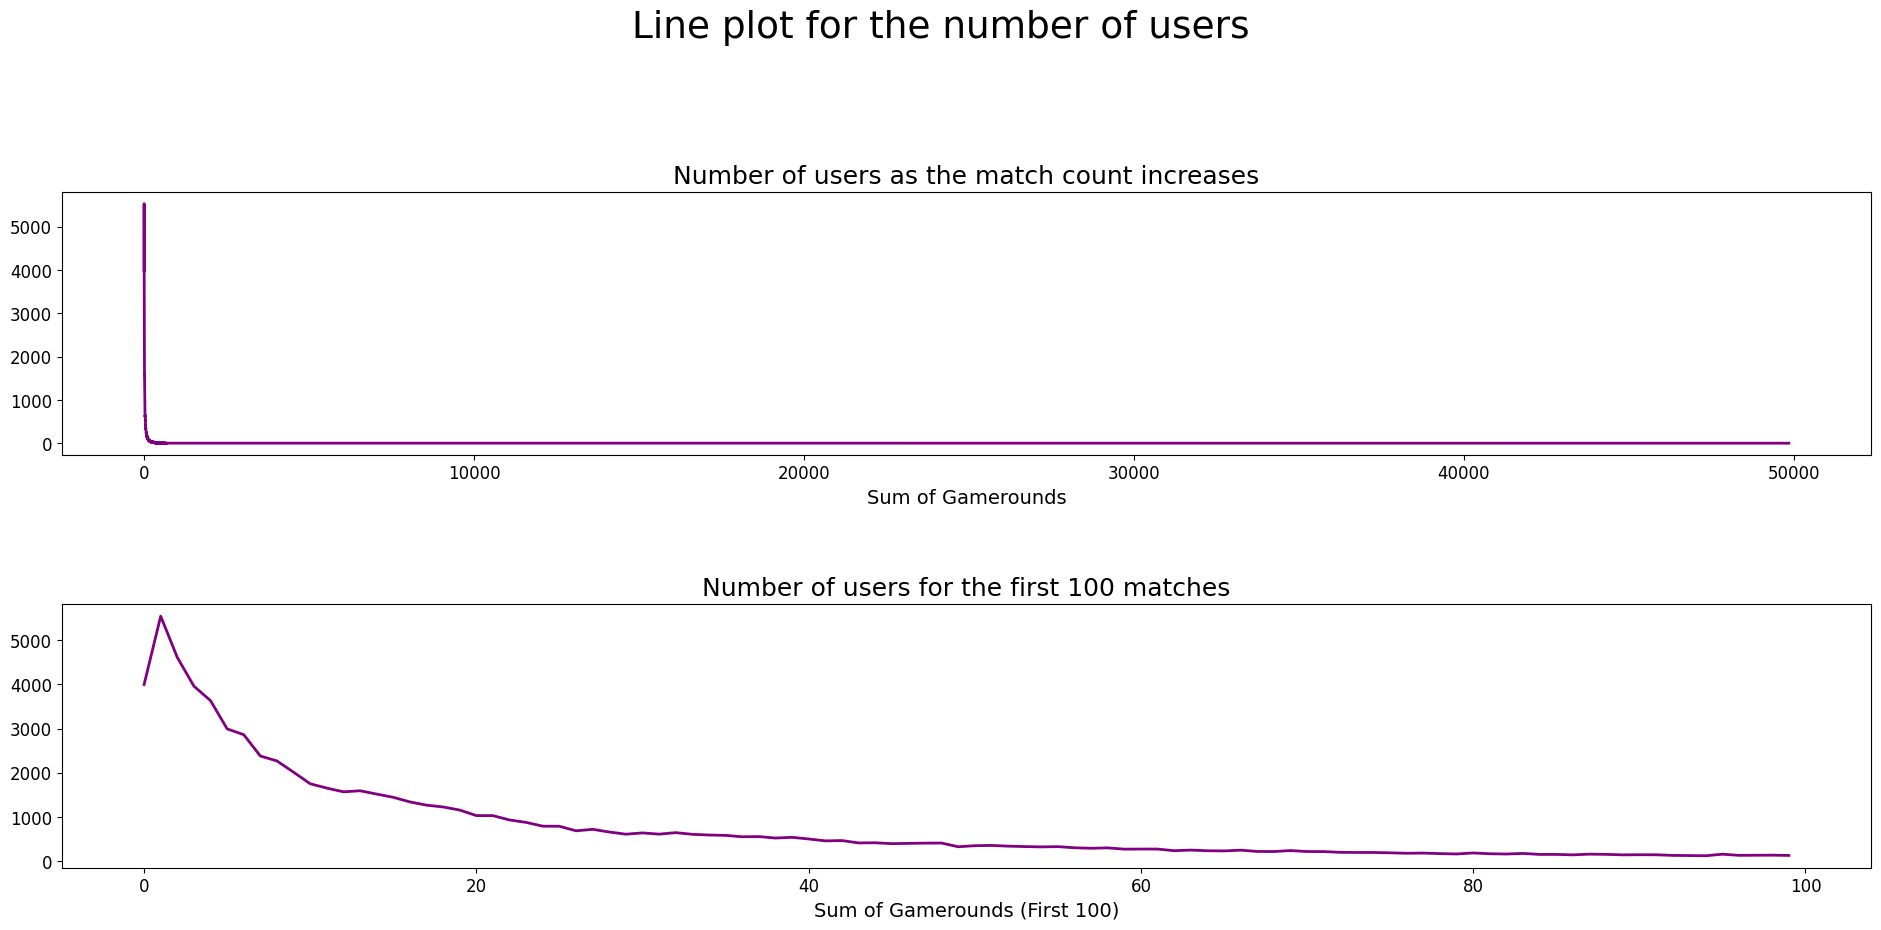

In [23]:
fig, axes = plt.subplots(2, 1, figsize = (20,10))
cookie_df.groupby("sum_gamerounds").userid.count().plot(ax = axes[0], color = 'purple', linewidth = 2)
cookie_df.groupby("sum_gamerounds").userid.count()[:100].plot(ax = axes[1], color = 'purple', linewidth = 2)
plt.suptitle("Line plot for the number of users", fontsize = 27)
axes[0].set_title("Number of users as the match count increases", fontsize = 18)
axes[1].set_title("Number of users for the first 100 matches", fontsize = 18)
axes[0].set_xlabel("Sum of Gamerounds", fontsize=14)
axes[1].set_xlabel("Sum of Gamerounds (First 100)", fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout(pad=5);
plt.show()

We observe that the number of players substantially drops before reaching twenty rounds and then reaches a plateau

In [25]:
print(f"The number of people coming back on the next day is {cookie_df['retention_1'].sum()}")
print(f"The number of people coming back after one week {cookie_df['retention_7'].sum()}")

The number of people coming back on the next day is 40153
The number of people coming back after one week 16781


In [26]:
#Everything is expected here
cookie_df.groupby("retention_1").sum_gamerounds.agg(["count", "mean", "std", "min", "max"])

,count,mean,std,min,max
retention_1,,,,,
False,50036,17.345651,225.725984,0,49854
True,40153,94.897467,136.472092,0,2961


In [27]:
#Everything is expected here
cookie_df.groupby("retention_7").sum_gamerounds.agg(["count", "mean", "std", "min", "max"])

,count,mean,std,min,max
retention_7,,,,,
False,73408,25.826844,43.871744,0,2640
True,16781,165.808236,424.394739,0,49854


Analyzing retention rates together with versions

In [28]:
cookie_df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std    max
version retention_1                                             
gate_30 False        24666     6.0  18.379591  319.423232  49854
        True         20034    48.0  94.411700  135.037697   2961
gate_40 False        25370     6.0  16.340402   35.925756   1241
        True         20119    49.0  95.381182  137.887256   2640

## Strange observations

In [82]:
#There are individuals that did not play one day after installing but came back a week later
cookie_df[(cookie_df['retention_1'] == False) & (cookie_df['retention_7'] == True)]

,userid,version,sum_gamerounds,retention_1,retention_7,version_AB,z_score
10,1842,gate_40,3,False,True,B,-0.250564
23,2729,gate_30,105,False,True,A,0.272379
90,8788,gate_30,19,False,True,A,-0.168534
102,10200,gate_40,106,False,True,B,0.277506
143,13429,gate_30,60,False,True,A,0.041669
...,...,...,...,...,...,...,...
89967,9975174,gate_30,26,False,True,A,-0.132645
90044,9982773,gate_30,1,False,True,A,-0.260818
90046,9983040,gate_30,137,False,True,A,0.436440
90156,9996093,gate_40,23,False,True,B,-0.148026


## Checking the data for potential outliers

In [76]:
def locate_outliers(df):
    df['z_score'] = zscore(df['sum_gamerounds'])

    outliers = df[df['z_score'].abs() > 3]

    return outliers

In [79]:
outlier_df = locate_outliers(cookie_df)
outlier_df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7,version_AB,z_score
601,63617,gate_30,902,True,True,A,4.358516
655,69927,gate_30,1906,True,True,A,9.505920
865,97308,gate_30,798,True,True,A,3.825319
1097,121303,gate_30,1374,True,True,A,6.778411
1264,139072,gate_40,681,False,True,B,3.225472
1444,156697,gate_30,762,True,True,A,3.640750
1707,185512,gate_40,934,True,True,B,4.522577
1891,204251,gate_30,750,True,True,A,3.579228
1968,213035,gate_40,784,False,True,B,3.753542
2257,248748,gate_30,1309,True,True,A,6.445163


# A/B Testing

In [89]:
from scipy.stats import normaltest, mannwhitneyu, levene, stats, kruskal
import matplotlib.pyplot as plt
cookie_df["version_AB"] = np.where(cookie_df.version == "gate_30", "A", "B")
gA = cookie_df[cookie_df['version_AB'] == "A"]['sum_gamerounds']
gB = cookie_df[cookie_df['version_AB'] == "B"]['sum_gamerounds']

## Checking normality conditions
The null hypothesis: The distribution is Normal 
The alternative hypothesis: The distribution is not normal

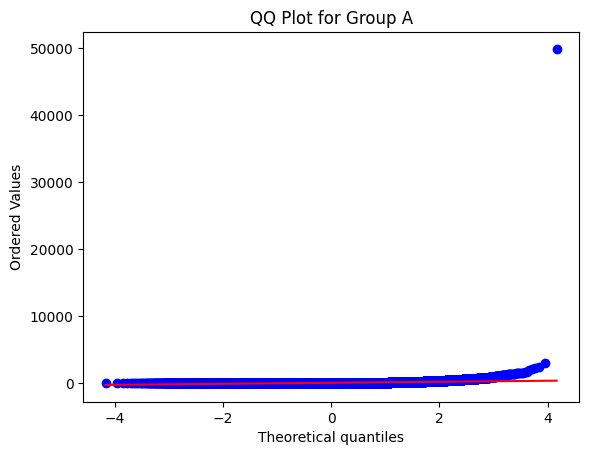

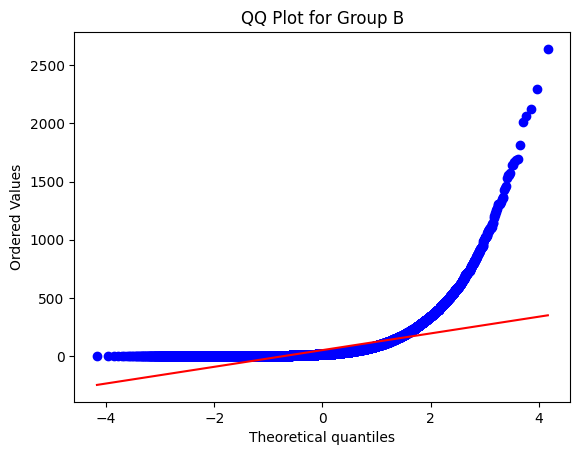

The test result for Group A is True, and the test result for Group B is True


In [46]:
# D’Agostino’s K-squared Test
ksA = normaltest(gA)[1] < 0.05
ksB = normaltest(gB)[1] < 0.05
stats.probplot(gA, dist="norm", plot=plt)
plt.title("QQ Plot for Group A")
plt.show()

# QQ Plot for Group B
stats.probplot(gB, dist="norm", plot=plt)
plt.title("QQ Plot for Group B")
plt.show()
print(f"The test result for Group A is {ksA}, and the test result for Group B is {ksB}")

Since both distributions are not normal, Mann-Whitney is one of the best tools for non-parametric comparison

In [54]:
U_stat, p_value = mannwhitneyu(gA, gB)
if p_value < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("There is no statistically significant difference between the groups.")

0.05020880772044255
There is no statistically significant difference between the groups.


In [65]:
# Trying the permutaton test instead of MWU 
n_simulations = 1000
g_a_length = len(gA)
g_b_length = len(gB)
all_users = pd.concat([gA, gB], ignore_index = True)
simulated_diffs = []


for i in range(n_simulations):
    users_shuffled = np.random.permutation(all_users)
    users_gA_simulated = users_shuffled[:g_a_length]
    gB_simulated = users_shuffled[g_a_length:]
    simulated_diff = np.mean(users_gA_simulated) - np.mean(gB_simulated)
    simulated_diffs.append(simulated_diff)
    
real_diff = np.mean(gA) - np.mean(gB)
upper_bound = np.quantile(simulated_diffs, 0.975)
lower_bound = np.quantile(simulated_diffs, 0.025)

In [66]:
print(lower_bound.round(2), upper_bound.round(2), real_diff.round(2))

-2.16 2.24 1.16


The real difference again lies inside the interval, indicating that the groups are not statistically significant

## Estimating the effect of version on retention

In [122]:
from scipy.stats import chi2_contingency


def chi2_pipe(df, col_name):
    count_df = df.groupby('version_AB')[col_name].agg(['sum', 'count'])
    # Rename columns for clarity
    count_df.columns = ['retained_count', 'total_count']
    count_df['not_retained_count'] = count_df['total_count'] - count_df['retained_count']
    contingency_table = count_df[['retained_count', 'not_retained_count']].T
    chi2, p, dof, expected = chi2_contingency(contingency_table) 
    return chi2, p, dof, expected, contingency_table
chi2, p, dof, expected, c_table = chi2_pipe(cookie_df, 'retention_1')
print(f"\nChi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:\n", pd.DataFrame(expected, index=c_table.index, columns=c_table.columns))


Chi-Square Statistic: 3.1591007878782262
p-value: 0.07550476210309098
Degrees of Freedom: 1
Expected Frequencies:
 version_AB                    A            B
retained_count      19900.86485  20252.13515
not_retained_count  24799.13515  25236.86485


In [119]:
chi2, p, dof, expected, c_table = chi2_pipe(cookie_df, 'retention_7')
print(f"\nChi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:\n", pd.DataFrame(expected, index=c_table.index, columns=c_table.columns))


Chi-Square Statistic: 9.959086799559167
p-value: 0.00160057426790583
Degrees of Freedom: 1
Expected Frequencies:
 version_AB                     A             B
retained_count       8317.097429   8463.902571
not_retained_count  36382.902571  37025.097429


Although the results are significant, there is virtually no difference between the retention rates

## Two-way comparison (only illustrative purpose)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [98]:
cookie_df['retention_status'] = np.select(
    [
        (cookie_df['retention_1'] == False) & (cookie_df['retention_7'] == False),
        (cookie_df['retention_1'] == True) & (cookie_df['retention_7'] == False),
        (cookie_df['retention_1'] == False) & (cookie_df['retention_7'] == True),
        (cookie_df['retention_1'] == True) & (cookie_df['retention_7'] == True)
    ],
    [
        'No_Retention', 
        'Retention_1_Only', 
        'Retention_7_Only', 
        'Both_Retentions'
    ],
    default='Unknown'  # Ensure the default is also a string
)

# Convert the version and retention status to categorical variables
cookie_df['version_cat'] = cookie_df['version'].astype('category')
cookie_df['retention_status_cat'] = cookie_df['retention_status'].astype('category')

In [94]:
groups = cookie_df.groupby(['version_cat', 'retention_status'])['sum_gamerounds']

# Extract each group as a separate series for Levene's test
group_values = [group for name, group in groups]

# Perform Levene's test to check for homogeneity of variances
levene_test = levene(*group_values)
print(f"Levene’s Test: W={levene_test.statistic}, p-value={levene_test.pvalue}")

Levene’s Test: W=561.7068433130363, p-value=0.0


/var/folders/1r/ljftvmg51t30bgx2cp783qbm0000gn/T/ipykernel_27687/598954629.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = cookie_df.groupby(['version_cat', 'retention_status'])['sum_gamerounds']


I cannot use the two-way ANOVA because the leven test failed

In [95]:
kruskal_test = kruskal(*group_values)
print(f"Kruskal-Wallis Test: H-statistic={kruskal_test.statistic}, p-value={kruskal_test.pvalue}")

Kruskal-Wallis Test: H-statistic=46332.581190302495, p-value=0.0


In [100]:
from scikit_posthocs import posthoc_dunn
cookie_df['group_kruskal'] = cookie_df['version'] + '_' + cookie_df['retention_status']
# Let's see which groups are different from one another
posthoc_results = posthoc_dunn(cookie_df, val_col='sum_gamerounds', group_col='group_kruskal', p_adjust='bonferroni')
print(posthoc_results)


                          gate_30_Both_Retentions  gate_30_No_Retention  \
gate_30_Both_Retentions              1.000000e+00                   0.0   
gate_30_No_Retention                 0.000000e+00                   1.0   
gate_30_Retention_1_Only             0.000000e+00                   0.0   
gate_30_Retention_7_Only            3.275379e-125                   0.0   
gate_40_Both_Retentions              1.000000e+00                   0.0   
gate_40_No_Retention                 0.000000e+00                   1.0   
gate_40_Retention_1_Only             0.000000e+00                   0.0   
gate_40_Retention_7_Only            1.494118e-117                   0.0   

                          gate_30_Retention_1_Only  gate_30_Retention_7_Only  \
gate_30_Both_Retentions               0.000000e+00             3.275379e-125   
gate_30_No_Retention                  0.000000e+00              0.000000e+00   
gate_30_Retention_1_Only              1.000000e+00              4.974376e-08   
gate

In [105]:
significant_pairs = posthoc_results[posthoc_results < 0.05]
significant_pairs = significant_pairs.stack().reset_index()
significant_pairs.columns = ['Group 1', 'Group 2', 'p-value']
    
    # Calculate the median difference between each pair of groups
group_medians = cookie_df.groupby('group_kruskal')['sum_gamerounds'].median()

# Add the difference in medians to the significant pairs
significant_pairs['Difference'] = significant_pairs.apply(
    lambda row: group_medians[row['Group 1']] - group_medians[row['Group 2']], axis=1
)

print("\nSignificant Pairs (p < 0.05) with Median Differences:")
print(significant_pairs)


Significant Pairs (p < 0.05) with Median Differences:
                     Group 1                   Group 2        p-value  \
0    gate_30_Both_Retentions      gate_30_No_Retention   0.000000e+00   
1    gate_30_Both_Retentions  gate_30_Retention_1_Only   0.000000e+00   
2    gate_30_Both_Retentions  gate_30_Retention_7_Only  3.275379e-125   
3    gate_30_Both_Retentions      gate_40_No_Retention   0.000000e+00   
4    gate_30_Both_Retentions  gate_40_Retention_1_Only   0.000000e+00   
5    gate_30_Both_Retentions  gate_40_Retention_7_Only  1.494118e-117   
6       gate_30_No_Retention   gate_30_Both_Retentions   0.000000e+00   
7       gate_30_No_Retention  gate_30_Retention_1_Only   0.000000e+00   
8       gate_30_No_Retention  gate_30_Retention_7_Only   0.000000e+00   
9       gate_30_No_Retention   gate_40_Both_Retentions   0.000000e+00   
10      gate_30_No_Retention  gate_40_Retention_1_Only   0.000000e+00   
11      gate_30_No_Retention  gate_40_Retention_7_Only   0.000000e+00

This two-way analysis is rather hard to interpret due to the fact that we do not have access to time data. 